# 1-3,文本数据建模流程范例

In [ ]:
import os

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


In [ ]:
!pip install gensim 
!pip install torchkeras

In [15]:
import torch 
import gensim
import torchkeras 
print("torch.__version__ = ", torch.__version__)
print("gensim.__version__ = ", gensim.__version__) 
print("torchkeras.__version__ = ", torchkeras.__version__) 


torch.__version__ =  2.0.1
gensim.__version__ =  4.3.1
torchkeras.__version__ =  3.9.3


<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


### 一，准备数据

imdb数据集的目标是根据电影评论的文本内容预测评论的情感标签。

训练集有20000条电影评论文本，测试集有5000条电影评论文本，其中正面评论和负面评论都各占一半。

文本数据预处理较为繁琐，包括文本切词，构建词典，编码转换，序列填充，构建数据管道等等。


此处使用gensim中的词典工具并自定义Dataset。

下面进行演示。


![](./data/电影评论.jpg)

In [92]:
import numpy as np 
import pandas as pd 
import torch 

MAX_LEN = 200           #每个样本保留200个词的长度
BATCH_SIZE = 20 


dftrain = pd.read_csv("./eat_pytorch_datasets/imdb/train.tsv",sep="\t",header = None,names = ["label","text"])
dfval = pd.read_csv("./eat_pytorch_datasets/imdb/test.tsv",sep="\t",header = None,names = ["label","text"])

In [106]:
from gensim import corpora
import string

#1，文本切词
def textsplit(text):
    translator = str.maketrans('', '', string.punctuation)
    words = text.translate(translator).split(' ')
    return words
        
#2，构建词典
vocab = corpora.Dictionary((textsplit(text) for text in dftrain['text']))
vocab.filter_extremes(no_below=5,no_above=5000)
special_tokens = {'<pad>': 0, '<unk>': 1}
vocab.patch_with_special_tokens(special_tokens)
vocab_size = len(vocab.token2id) 
print('vocab_size = ',vocab_size)

#3，序列填充
def pad(seq,max_length,pad_value=0):
    n = len(seq)
    result = seq+[pad_value]*max_length
    return result[:max_length]


#4，编码转换
def text_pipeline(text):
    tokens = vocab.doc2idx(textsplit(text))
    tokens = [x if x>0 else special_tokens['<unk>']  for x in tokens ]
    result = pad(tokens,MAX_LEN,special_tokens['<pad>'])
    return result 

print(text_pipeline("this is an example!")) 


vocab_size =  29924
[145, 77, 569, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [107]:
#5，构建管道
from torch.utils.data import Dataset,DataLoader

class ImdbDataset(Dataset):
    def __init__(self,df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        text = self.df["text"].iloc[index]
        label = torch.tensor([self.df["label"].iloc[index]]).float()
        tokens = torch.tensor(text_pipeline(text)).int() 
        return tokens,label
    
ds_train = ImdbDataset(dftrain)
ds_val = ImdbDataset(dfval)


In [108]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = False)


In [109]:
for features,labels in dl_train:
    break 

### 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择使用第三种方式进行构建。


In [110]:
import torch
from torch import nn 
torch.manual_seed(42)


In [111]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #设置padding_idx参数后将在训练过程中将填充的token始终赋值为0向量
        self.embedding = nn.Embedding(num_embeddings = vocab_size,embedding_dim = 3,padding_idx = 0)
        
        self.conv = nn.Sequential()
        self.conv.add_module("conv_1",nn.Conv1d(in_channels = 3,out_channels = 16,kernel_size = 5))
        self.conv.add_module("pool_1",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_1",nn.ReLU())
        self.conv.add_module("conv_2",nn.Conv1d(in_channels = 16,out_channels = 128,kernel_size = 2))
        self.conv.add_module("pool_2",nn.MaxPool1d(kernel_size = 2))
        self.conv.add_module("relu_2",nn.ReLU())
        
        self.dense = nn.Sequential()
        self.dense.add_module("flatten",nn.Flatten())
        self.dense.add_module("linear",nn.Linear(6144,1))
        
        
    def forward(self,x):
        x = self.embedding(x).transpose(1,2)
        x = self.conv(x)
        y = self.dense(x)
        return y
        
net = Net() 
print(net)

Net(
  (embedding): Embedding(29924, 3, padding_idx=0)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
  )
)


```
Net(
  (embedding): Embedding(8813, 3, padding_idx=0)
  (conv): Sequential(
    (conv_1): Conv1d(3, 16, kernel_size=(5,), stride=(1,))
    (pool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (pool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (dense): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=6144, out_features=1, bias=True)
  )
)
```

In [112]:
from torchkeras import summary 
summary(net,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Embedding-1                             [-1, 200, 3]               89,772
Conv1d-2                               [-1, 16, 196]                  256
MaxPool1d-3                             [-1, 16, 98]                    0
ReLU-4                                  [-1, 16, 98]                    0
Conv1d-5                               [-1, 128, 97]                4,224
MaxPool1d-6                            [-1, 128, 48]                    0
ReLU-7                                 [-1, 128, 48]                    0
Flatten-8                                 [-1, 6144]                    0
Linear-9                                     [-1, 1]                6,145
Total params: 100,397
Trainable params: 100,397
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/back

### 三，训练模型

训练Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的仿照Keras风格的类形式的训练循环。

该训练循环的代码也是torchkeras库的核心代码。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 



In [113]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn,stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
    
    def __call__(self, features, labels):
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)

        #backward()
        if self.optimizer is not None and self.stage=="train":
            loss.backward()
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics


class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.steprunner.net.train() if self.stage=="train" else self.steprunner.net.eval()
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop: 
            if self.stage=="train":
                loss, step_metrics = self.steprunner(*batch)
            else:
                with torch.no_grad():
                    loss, step_metrics = self.steprunner(*batch)
            step_log = dict({self.stage+"_loss":loss},**step_metrics)

            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log

class KerasModel(torch.nn.Module):
    def __init__(self,net,loss_fn,metrics_dict=None,optimizer=None,lr_scheduler = None):
        super().__init__()
        self.history = {}
        
        self.net = net
        self.loss_fn = loss_fn
        self.metrics_dict = nn.ModuleDict(metrics_dict) 
        
        self.optimizer = optimizer if optimizer is not None else torch.optim.Adam(
            self.parameters(), lr=1e-2)
        self.lr_scheduler = lr_scheduler

    def forward(self, x):
        if self.net:
            return self.net.forward(x)
        else:
            raise NotImplementedError


    def fit(self, train_data, val_data=None, epochs=10, ckpt_path='checkpoint.pt', 
            patience=5, monitor="val_loss", mode="min"):

        for epoch in range(1, epochs+1):
            printlog("Epoch {0} / {1}".format(epoch, epochs))
            
            # 1，train -------------------------------------------------  
            train_step_runner = StepRunner(net = self.net,stage="train",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict),
                    optimizer = self.optimizer, lr_scheduler = self.lr_scheduler)
            train_epoch_runner = EpochRunner(train_step_runner)
            train_metrics = train_epoch_runner(train_data)
            
            for name, metric in train_metrics.items():
                self.history[name] = self.history.get(name, []) + [metric]

            # 2，validate -------------------------------------------------
            if val_data:
                val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict))
                val_epoch_runner = EpochRunner(val_step_runner)
                with torch.no_grad():
                    val_metrics = val_epoch_runner(val_data)
                val_metrics["epoch"] = epoch
                for name, metric in val_metrics.items():
                    self.history[name] = self.history.get(name, []) + [metric]
            
            # 3，early-stopping -------------------------------------------------
            if not val_data:
                continue
            arr_scores = self.history[monitor]
            best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
            if best_score_idx==len(arr_scores)-1:
                torch.save(self.net.state_dict(),ckpt_path)
                print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                     arr_scores[best_score_idx]),file=sys.stderr)
            if len(arr_scores)-best_score_idx>patience:
                print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                    monitor,patience),file=sys.stderr)
                break 
                
        self.net.load_state_dict(torch.load(ckpt_path))  
        return pd.DataFrame(self.history)

    @torch.no_grad()
    def evaluate(self, val_data):
        val_step_runner = StepRunner(net = self.net,stage="val",
                    loss_fn = self.loss_fn,metrics_dict=deepcopy(self.metrics_dict))
        val_epoch_runner = EpochRunner(val_step_runner)
        val_metrics = val_epoch_runner(val_data)
        return val_metrics
        
       
    @torch.no_grad()
    def predict(self, dataloader):
        self.net.eval()
        result = torch.cat([self.forward(t[0]) for t in dataloader])
        return result.data


In [115]:
from torchmetrics import Accuracy

net = Net() 
model = KerasModel(net,
                  loss_fn = nn.BCEWithLogitsLoss(),
                  optimizer= torch.optim.Adam(net.parameters(),lr = 0.01),  
                  metrics_dict = {"acc":Accuracy(task='binary')}
                )


In [116]:
model.fit(dl_train,
    val_data=dl_val,
    epochs=10,
    ckpt_path='checkpoint',
    patience=3,
    monitor='val_acc',
    mode='max')



================================================================================2023-08-02 14:20:21
Epoch 1 / 10



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.21it/s, val_acc=0.518, val_loss=0.693]
<<<<<< reach best val_acc : 0.5180000066757202 >>>>>>



================================================================================2023-08-02 14:20:33
Epoch 2 / 10



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.22it/s, val_acc=0.58, val_loss=0.689]
<<<<<< reach best val_acc : 0.5803999900817871 >>>>>>



================================================================================2023-08-02 14:20:45
Epoch 3 / 10



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.84it/s, val_acc=0.781, val_loss=0.47]
<<<<<< reach best val_acc : 0.7807999849319458 >>>>>>



================================================================================2023-08-02 14:20:57
Epoch 4 / 10



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 54.18it/s, val_acc=0.819, val_loss=0.408]
<<<<<< reach best val_acc : 0.8194000124931335 >>>>>>



================================================================================2023-08-02 14:21:09
Epoch 5 / 10



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.69it/s, val_acc=0.836, val_loss=0.395]
<<<<<< reach best val_acc : 0.8357999920845032 >>>>>>



================================================================================2023-08-02 14:21:21
Epoch 6 / 10



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.93it/s, val_acc=0.828, val_loss=0.456]



================================================================================2023-08-02 14:21:33
Epoch 7 / 10



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.26it/s, val_acc=0.829, val_loss=0.558]



================================================================================2023-08-02 14:21:44
Epoch 8 / 10



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.91it/s, val_acc=0.823, val_loss=0.67]
<<<<<< val_acc without improvement in 3 epoch, early stopping >>>>>>


,train_loss,train_acc,val_loss,val_acc,epoch
0,0.701064,0.49580,0.693045,0.5180,1
1,0.693060,0.50335,0.688656,0.5804,2
2,0.579867,0.69010,0.469574,0.7808,3
3,0.385625,0.82990,0.407633,0.8194,4
4,0.261653,0.89260,0.394901,0.8358,5
5,0.175921,0.93210,0.455604,0.8284,6
6,0.119178,0.95610,0.558430,0.8286,7
7,0.075409,0.97330,0.670172,0.8232,8


### 四，评估模型

In [117]:
import pandas as pd 

history = model.history
dfhistory = pd.DataFrame(history) 
dfhistory 


,train_loss,train_acc,val_loss,val_acc,epoch
0,0.701064,0.49580,0.693045,0.5180,1
1,0.693060,0.50335,0.688656,0.5804,2
2,0.579867,0.69010,0.469574,0.7808,3
3,0.385625,0.82990,0.407633,0.8194,4
4,0.261653,0.89260,0.394901,0.8358,5
5,0.175921,0.93210,0.455604,0.8284,6
6,0.119178,0.95610,0.558430,0.8286,7
7,0.075409,0.97330,0.670172,0.8232,8


In [118]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

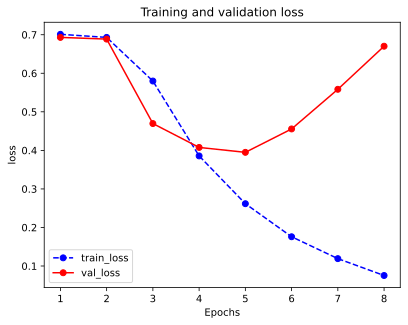

In [119]:
plot_metric(dfhistory,"loss")

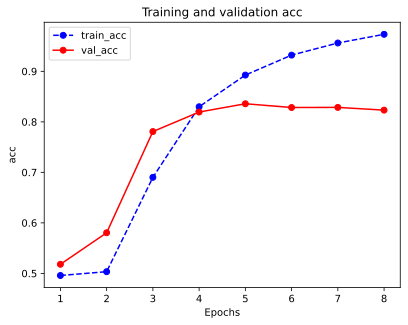

In [120]:
plot_metric(dfhistory,"acc")

In [121]:
# 评估
model.evaluate(dl_val)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.26it/s, val_acc=0.836, val_loss=0.395]


{'val_loss': 0.39490113019943235, 'val_acc': 0.8357999920845032}

### 五，使用模型

In [122]:
def predict(net,dl):
    net.eval()
    with torch.no_grad():
        result = nn.Sigmoid()(torch.cat([net.forward(t[0]) for t in dl]))
    return(result.data)


In [123]:
y_pred_probs = predict(net,dl_val)
y_pred_probs

tensor([[0.9372],
        [1.0000],
        [0.8672],
        ...,
        [0.5141],
        [0.4756],
        [0.9998]])

### 六，保存模型

In [124]:
#模型权重已经被保存在了ckpt_path='checkpoint.'
net_clone = Net()
net_clone.load_state_dict(torch.load('checkpoint'))


<All keys matched successfully>

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)